# Wait.. but what is the Exploratory Data Analysis (EDA)?
> In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task. Exploratory data analysis was promoted by John Tukey to encourage statisticians to explore the data, and possibly formulate hypotheses that could lead to new data collection and experiments. EDA is different from initial data analysis (IDA),[1] which focuses more narrowly on checking assumptions required for model fitting and hypothesis testing, and handling missing values and making transformations of variables as needed. EDA encompasses IDA. __Wikipedia__

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pandas import DataFrame
init_notebook_mode(connected=True)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit
from scipy.stats import norm

## Dataset prepration

In [1]:
data = DataFrame.from_csv("./testosterone_levels.csv")

# whole population
mean_std = np.array([[t.mean(), t.std()] for t in testosterones])
cv = (mean_std[:, 1] / mean_std[:, 0]) * 100

# gender specific population
gender = data.groupby("Person").first()['F1']
male = data[data['F1'] == 1]
female = data[data['F1'] == 2]
male_testosterones = [p.Testosterone for _, p in male.groupby("Person")]
female_testosterones = [p.Testosterone for _, p in female.groupby("Person")]

mean_std_male = np.array([[t.mean(), t.std()] for t in male_testosterones])
mean_std_female = np.array([[t.mean(), t.std()] for t in female_testosterones])
cv_male = (mean_std_male[:, 1] / mean_std_male[:, 0]) * 100
cv_female = (mean_std_female[:, 1] / mean_std_female[:, 0]) * 100

testosterones = [p.Testosterone for _, p in data.groupby("Person")]

## Total Population

### General trends of Testosterone in all athletes

In [26]:
plotData = []
for test in testosterones:
    plotData.append(go.Scatter(x= np.arange(len(test)), y= test.values, name=testosterones[0].index[0], showlegend=False)) 

layout = dict(title = 'Whole population testosterone',
              xaxis = dict(title = 'Samples'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### What does the distribution of log mean of testosterone look like?

mu1: 0.65, mu2: 2.31, sigma1: 0.32, sigma2: 0.48


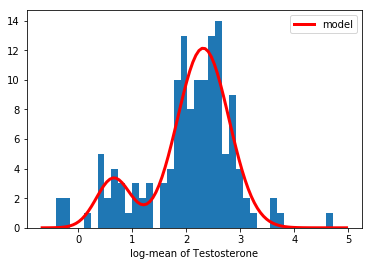

In [21]:
def bimodal(x, mu1, sigma1, a, mu2, sigma2, b):
    return a * norm.pdf(x, loc=mu1, scale=sigma1) + b * norm.pdf(x, loc=mu2, scale=sigma2)

y, x, _ = plt.hist(np.log(mean_std[:, 0]), bins=40)

x = (x[1:] + x[:-1]) / 2  # for len(x)==len(y)

expected = (.9, .3, 5, 2, .5, 25)
params, cov = curve_fit(bimodal, x, y, expected)

x_min, x_max = plt.xlim()
x_range = np.linspace(x_min, x_max, 100)

plt.plot(x_range, bimodal(x_range, *params), color='red', lw=3, label='model')
plt.xlabel("log-mean of Testosterone")

plt.legend()
print("mu1: %.2f, mu2: %.2f, sigma1: %.2f, sigma2: %.2f" % (params[0], params[3], params[1], params[4]))

## Male population

### General trends of testosterone in male athletes

In [60]:
plotData = []
for test in male_testosterones:
    plotData.append(go.Scatter(x= np.arange(len(test)), y= test.values, name=test.index[0], showlegend=False)) 

layout = dict(title = 'Male population testosterone',
              xaxis = dict(title = 'Samples'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### Testosterone distributions per athletes

In [43]:
plotData = []
for test in male_testosterones:
    plotData.append(go.Box(y= test, showlegend=False))
layout = dict(title = 'Distribution testosterone male athletes ',
              xaxis = dict(title = 'Athletes'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### Can testosterone trends be modeled with the linear line?

In [307]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline([('poly', PolynomialFeatures(degree=1)),('linear', LinearRegression(fit_intercept=False))])

errors = []
residuals = []
for y in male_testosterones:
    x = np.arange(len(y))
    model = model.fit(np.arange(len(y))[:, np.newaxis], y)
    y_hat = model.named_steps['linear'].coef_[0] + model.named_steps['linear'].coef_[1] * x
    residual = y - y_hat
    error = np.mean((residual) ** 2) ** .5
    errors.append(error)
    residuals.append(residual)

data = [go.Box(y=residual, hoverinfo=residual.index[0]) for residual in residuals]
iplot(data)

In [300]:
total_var = [np.var(res) for res in residuals]
DataFrame(total_var).describe()

,0
count,107.000000
mean,1.353844
std,3.459832
min,0.000646
25%,0.104300
50%,0.282944
75%,1.048539
max,28.863435


It seems that there are some athletes that do not follow the linear model. This can be confirmed by that fact that for those athletes the linear model has a large variance in the residuals. Another fact that can be easily implied by the distribution of residuals is that we can detect abnormal observations (test results) which fall outside the 99% percentile of the residual distribution. By visually inspecting such cases we confirmed that those test results show a sudden increase compared to the general trend of observations. The next question is that whether we can model rest of athletes with high variance with a non-linear model.

### What happenes when we model residuals with non-linear models?

In [311]:
model_quad = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])

residuals_quad = []
quad_coefs = []
for y in male_testosterones:
    x = np.arange(len(y))
    model_quad = model_quad.fit(np.arange(len(y))[:, np.newaxis], y)
    y_hat_quad = model_quad.named_steps['linear'].coef_[0] + model_quad.named_steps['linear'].coef_[1] * x + model_quad.named_steps['linear'].coef_[2] * (x** 2)
    residual_quad = y - y_hat_quad
    quad_coefs.append(model_quad.named_steps['linear'].coef_) 
    residuals_quad.append(residual_quad)

data = [go.Box(y=residual_quad, hoverinfo=residual_quad.index[0]) for residual_quad in residuals_quad]
iplot(data)

In [301]:
total_var_quad = [np.var(res) for res in residuals_quad]
DataFrame(total_var_quad).describe()

,0
count,107.000000
mean,0.774351
std,2.449339
min,0.000633
25%,0.035161
50%,0.160113
75%,0.501466
max,22.543074


By increasing the flexibility of the model from linear to non-linear, obviously, the variance is decreased. That is the model is able to fit more observations and this might result in considering outlier points less than before. The athletes for which the box plot of residuals shows some outlier points (in non-linear case) there is a strong indication that such observations are abnormal. We have confirmed this fact by visually inspecting these cases.

In [309]:
def show_testosterone_and_predictions(index, model_coefs, is_male=True):
    y = male_testosterones[index] if is_male else female_testosterones[index]
    x = np.arange(len(y))
    y_hat = model_coefs[index][0] + model_coefs[index][1] * x + model_coefs[index][2] * (x**2)
    plt.plot(x, y, label="testosterone")
    plt.plot(x, y_hat, label="prediction")
    plt.legend()

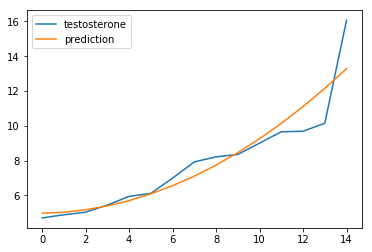

In [312]:
show_testosterone_and_predictions(48, quad_coefs)

## How can we comfirm that the residuals follow normal distributions?

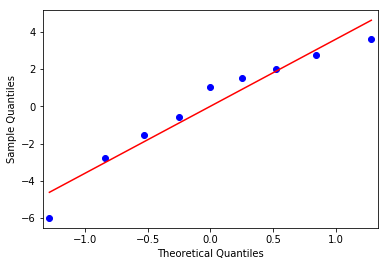

In [220]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals[16], line='r')
plt.show()

## Female population

### General trends of testosterone in female athletes

In [28]:
plotData = []
for test in female_testosterones:
    plotData.append(go.Scatter(x= np.arange(len(test)), y= test.values, name=testosterones[0].index[0], showlegend=False)) 

layout = dict(title = 'Female population testosterone',
              xaxis = dict(title = 'Samples'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### Testosterone distributions per athletes

In [44]:
plotData = []
for test in female_testosterones:
    plotData.append(go.Box(y= test, showlegend=False))
layout = dict(title = 'Distribution testosterone female athletes ',
              xaxis = dict(title = 'Athletes'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### Can a same quadratic pattern be found for women?

In [313]:
model_quad = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])

residuals_quad = []
quad_coefs = []
for y in female_testosterones:
    x = np.arange(len(y))
    model_quad = model_quad.fit(np.arange(len(y))[:, np.newaxis], y)
    y_hat_quad = model_quad.named_steps['linear'].coef_[0] + model_quad.named_steps['linear'].coef_[1] * x + model_quad.named_steps['linear'].coef_[2] * (x** 2)
    residual_quad = y - y_hat_quad
    quad_coefs.append(model_quad.named_steps['linear'].coef_) 
    residuals_quad.append(residual_quad)

data = [go.Box(y=residual_quad, hoverinfo=residual_quad.index[0]) for residual_quad in residuals_quad]
iplot(data)

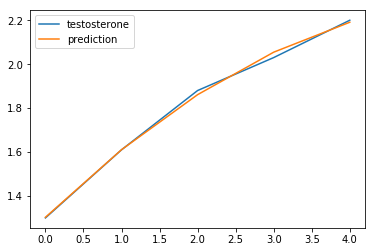

In [330]:
show_testosterone_and_predictions(19, quad_coefs, False)

Same as male athlete using non-linear fits for women athlets can almost perfectly describe the trends of testosterones. Athletes with high variance shows abnormal patterns.